In [46]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from scripts.data_builder import HydroForecastData

import glob
import pandas as pd
import xarray as xr
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import (TimeSeriesDataSet, TemporalFusionTransformer,
                                 Baseline)
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, RMSE
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric

torch.set_float32_matmul_precision('medium')

In [3]:
static_attributes = pd.read_csv('/workspaces/my_dissertation/geo_data/attributes/static_data.csv',
                                index_col='gauge_id')
static_attributes.index = static_attributes.index.astype(str)
static_attributes = static_attributes[['for_pc_sse', 'crp_pc_sse',
                                       'inu_pc_ult', 'ire_pc_sse',
                                       'lka_pc_use', 'prm_pc_sse',
                                       'pst_pc_sse', 'cly_pc_sav',
                                       'slt_pc_sav', 'snd_pc_sav',
                                       'kar_pc_sse', 'urb_pc_sse',
                                       'gwt_cm_sav', 'lkv_mc_usu',
                                       'rev_mc_usu', 'sgr_dk_sav',
                                       'slp_dg_sav', 'ws_area', 'ele_mt_sav']]

In [4]:
def open_for_tft(file_path: str,
                 attributes: pd.DataFrame) -> pd.DataFrame:
    
    gauge_id = file_path.split('/')[-1][:-3]
    
    gauge_static = attributes.loc[[gauge_id], :]
    
    file = xr.open_dataset(file_path)
    file = file.to_dataframe()
    # file['date'] = file.index
    file = file.reset_index()
    file['time_idx'] = file.index
    
    for col in gauge_static.columns:
        file[col] = gauge_static[col].values[0]
        
    return file

file = pd.concat(open_for_tft(file,
                              static_attributes)
                 for file in glob.glob('../geo_data/time_series/*.nc')[6:10])
file = file.reset_index(drop=True)
file

,date,lvl_sm,q_cms_s,lvl_mbs,q_mm_day,t_max_e5l,t_max_e5,t_min_e5l,t_min_e5,prcp_e5l,...,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,sgr_dk_sav,slp_dg_sav,ws_area,ele_mt_sav
0,2008-01-01,218.0,440.00,84.70,NaN,-14.042278,-14.347820,-20.369324,-21.092424,2.630586,...,35.071723,10.54781,1.083932,181.138057,1708.609214,39.489374,139.214096,6.980446,255208.058757,782.792565
1,2008-01-02,218.0,440.00,84.70,NaN,-12.795704,-12.573386,-21.140511,-22.195318,1.609834,...,35.071723,10.54781,1.083932,181.138057,1708.609214,39.489374,139.214096,6.980446,255208.058757,782.792565
2,2008-01-03,218.0,440.00,84.70,NaN,-16.682955,-17.177605,-27.783049,-30.258742,1.049677,...,35.071723,10.54781,1.083932,181.138057,1708.609214,39.489374,139.214096,6.980446,255208.058757,782.792565
3,2008-01-04,217.0,437.00,84.69,NaN,-24.430304,-24.470978,-31.790465,-33.819618,1.151591,...,35.071723,10.54781,1.083932,181.138057,1708.609214,39.489374,139.214096,6.980446,255208.058757,782.792565
4,2008-01-05,216.0,437.00,84.68,NaN,-19.967763,-20.174912,-32.162585,-34.281782,0.998019,...,35.071723,10.54781,1.083932,181.138057,1708.609214,39.489374,139.214096,6.980446,255208.058757,782.792565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18991,2020-12-27,137.0,1.08,111.07,NaN,-10.046339,-10.106445,-19.234768,-23.687982,0.192768,...,67.822001,0.00000,0.000000,69.531202,26.918954,0.000000,35.525094,1.524779,136.742908,142.784882
18992,2020-12-28,135.0,1.05,111.05,NaN,-5.436632,-5.251622,-9.324132,-9.607189,2.106680,...,67.822001,0.00000,0.000000,69.531202,26.918954,0.000000,35.525094,1.524779,136.742908,142.784882
18993,2020-12-29,131.0,1.02,111.01,NaN,-4.856397,-5.245349,-6.408456,-6.954955,2.849133,...,67.822001,0.00000,0.000000,69.531202,26.918954,0.000000,35.525094,1.524779,136.742908,142.784882
18994,2020-12-30,130.0,1.00,111.00,NaN,-5.667886,-6.078617,-7.321406,-8.293867,4.028508,...,67.822001,0.00000,0.000000,69.531202,26.918954,0.000000,35.525094,1.524779,136.742908,142.784882


In [5]:
# define dataset
encoder_length = 365
prediction_length = 7
training_cutoff = "2017-12-31"  # day for cutoff

file = file[['date', 'time_idx',
             'q_cms_s', 'prcp_e5l',  't_max_e5l', 't_min_e5l',
             'gauge_id',
             'for_pc_sse', 'crp_pc_sse',
             'inu_pc_ult', 'ire_pc_sse',
             'lka_pc_use', 'prm_pc_sse',
             'pst_pc_sse', 'cly_pc_sav',
             'slt_pc_sav', 'snd_pc_sav',
             'kar_pc_sse', 'urb_pc_sse',
             'gwt_cm_sav', 'lkv_mc_usu',
             'rev_mc_usu', 'sgr_dk_sav',
             'slp_dg_sav', 'ws_area', 'ele_mt_sav']]

train_df = file[lambda x: x.date <= training_cutoff].reset_index(drop=True)  # type: ignore
train_df['time_idx'] = train_df.index
val_df = file[lambda x: x.date > training_cutoff].reset_index(drop=True)  # type: ignore
val_df['time_idx'] = val_df.index


In [6]:
training = TimeSeriesDataSet(
    data=train_df,  # type: ignore
    time_idx="time_idx",
    target="q_cms_s",
    group_ids=["gauge_id"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["q_cms_s"],
    max_encoder_length=encoder_length,
    max_prediction_length=prediction_length,
    static_reals=['for_pc_sse', 'crp_pc_sse',
                  'inu_pc_ult', 'ire_pc_sse',
                  'lka_pc_use', 'prm_pc_sse',
                  'pst_pc_sse', 'cly_pc_sav',
                  'slt_pc_sav', 'snd_pc_sav',
                  'kar_pc_sse', 'urb_pc_sse',
                  'gwt_cm_sav', 'lkv_mc_usu',
                  'rev_mc_usu', 'sgr_dk_sav',
                  'slp_dg_sav', 'ws_area', 'ele_mt_sav'],
    time_varying_known_reals=['t_max_e5l', 't_min_e5l', 'prcp_e5l'])
# create validation set (predict=True) which means
# to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training,
                                            val_df)
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size,
                                          num_workers=0)

### Baseline model

In [7]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

53.54053497314453

### Find optimal learning rate

In [11]:
class MALELoss(MultiHorizonMetric):
        
    def loss(self, y_pred, target):
        
        y_pred = self.to_prediction(y_pred)

        return torch.mean(torch.abs(torch.log(y_pred) - torch.log(target)))


In [13]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    dropout=0.24,
    hidden_continuous_size=64,
    loss=MALELoss(),
    reduce_on_plateau_patience=420,
    optimizer='adam')

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 672.5k


Missing logger folder: /workspaces/my_dissertation/forecast/lightning_logs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /workspaces/my_dissertation/forecast/.lr_find_93e4d339-8b53-4875-855c-d1606edf6304.ckpt
Restored all states from the checkpoint file at /workspaces/my_dissertation/forecast/.lr_find_93e4d339-8b53-4875-855c-d1606edf6304.ckpt


suggested learning rate: 0.07079457843841377


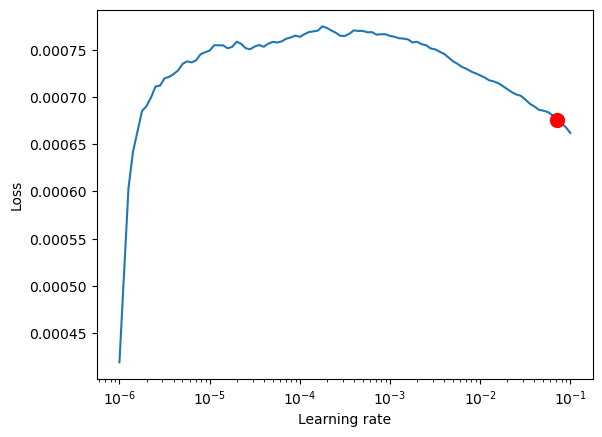

In [82]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-6)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [14]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4, patience=10,
                                    verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    enable_model_summary=True,
    check_val_every_n_epoch=3,
    gradient_clip_val=0.2,
    limit_train_batches=42,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=64,
    dropout=0.24,
    hidden_continuous_size=64,
    loss=MALELoss(),
    reduce_on_plateau_patience=420)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 672.5k


In [15]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MALELoss                        | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 345 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 68.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 51.5 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=6,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [16]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(156.9221)

In [45]:
for n_iter in range(100):
    logger.add_scalar('Loss/train', np.random.random(), n_iter)
    logger.add_scalar('Loss/test', np.random.random(), n_iter)
    logger.add_scalar('Accuracy/train', np.random.random(), n_iter)
    logger.add_scalar('Accuracy/test', np.random.random(), n_iter)

AttributeError: 'TensorBoardLogger' object has no attribute 'add_scalar'

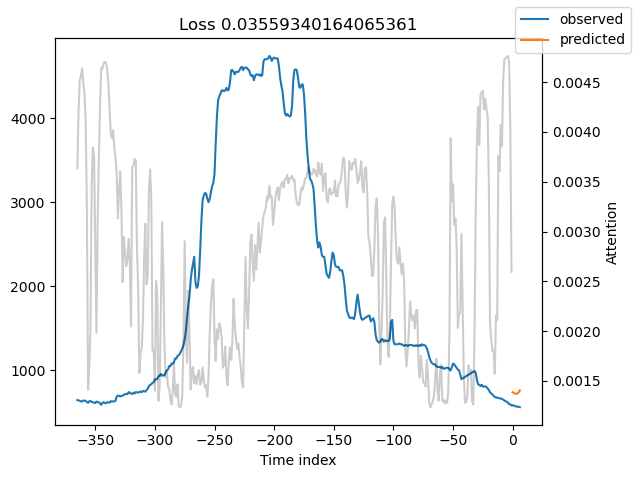

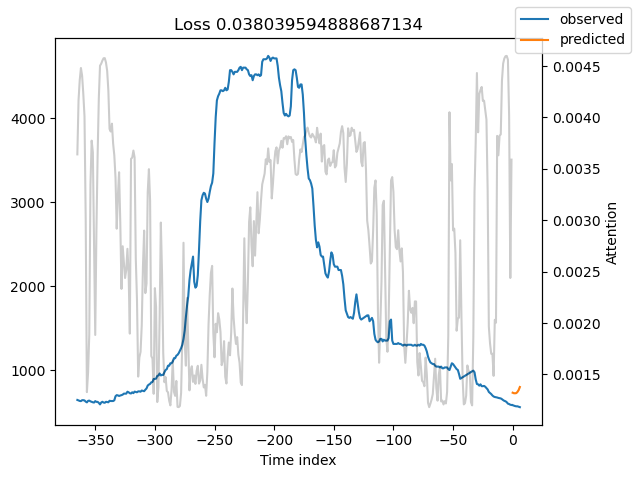

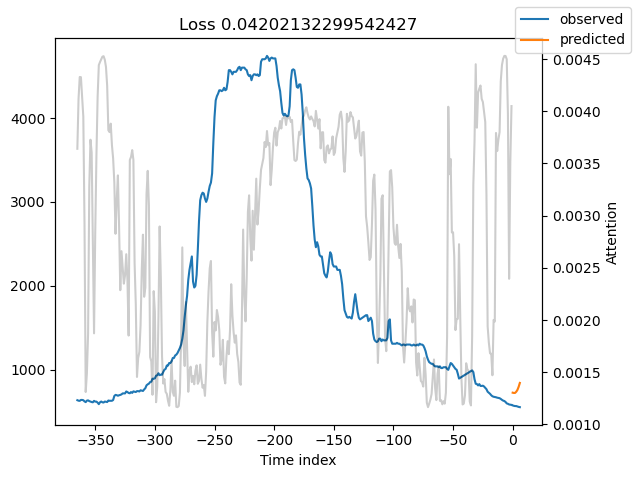

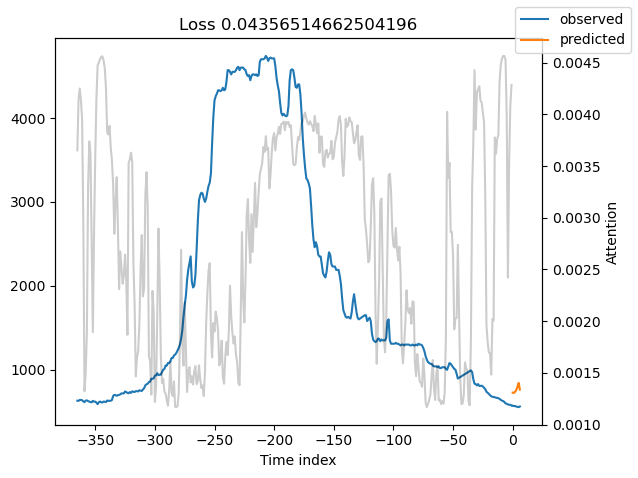

In [51]:
for idx in range(4):  # plot 10 examples
    best_tft.plot_prediction(x, raw_prediction, idx=idx,
                             add_loss_to_title=True);

In [52]:
tensorboard --logdir=lightning_logs

In [22]:
np.unique(val_df['gauge_id'])

array(['10015', '3293', '49128', '78519'], dtype=object)

In [35]:
raw_prediction, x, idx = best_tft.predict(
    validation.filter(lambda x: x.gauge_id=='10015'),
    mode="raw",
    return_x=True,
    return_index=True)
idx.loc[:, 'date'] = val_df['date'][idx['time_idx']].values

In [36]:
res = np.array([])
size_pred = len(raw_prediction['prediction'])
for i, prediction in enumerate(raw_prediction['prediction']):
    if i+6 == size_pred:
        break
    prediction = prediction.squeeze()
    res = np.concatenate([res[:i], prediction])
idx.loc[:, 'pred'] = res
idx.loc[:, 'obs'] = val_df['q_cms_s'][idx['time_idx']].values

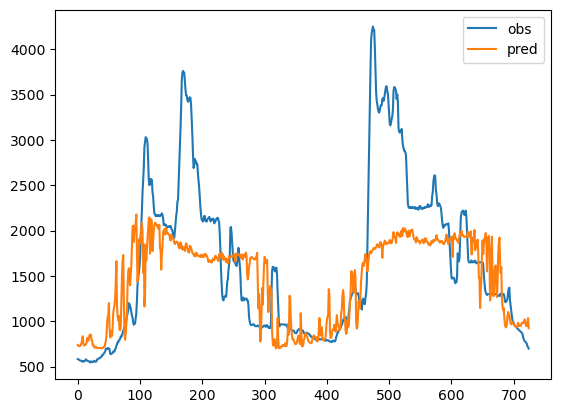

In [37]:
idx[['obs', 'pred']].plot();

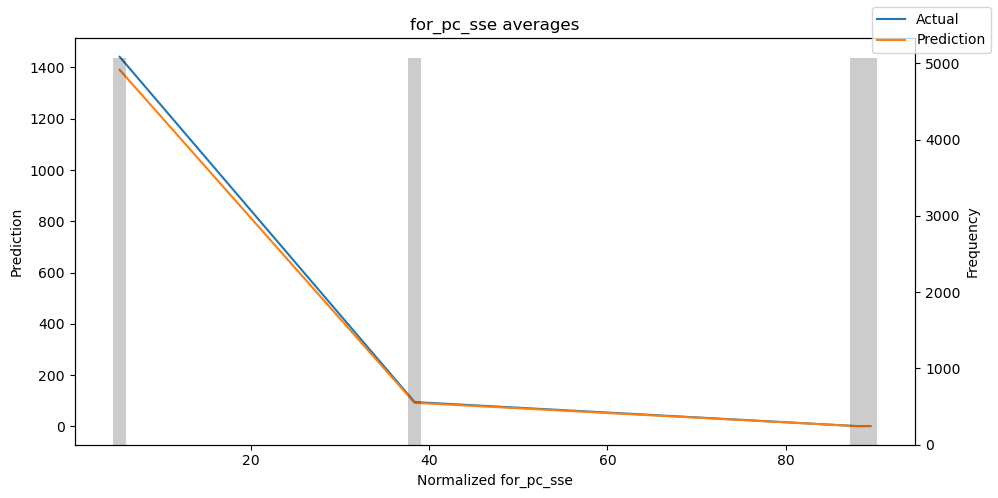

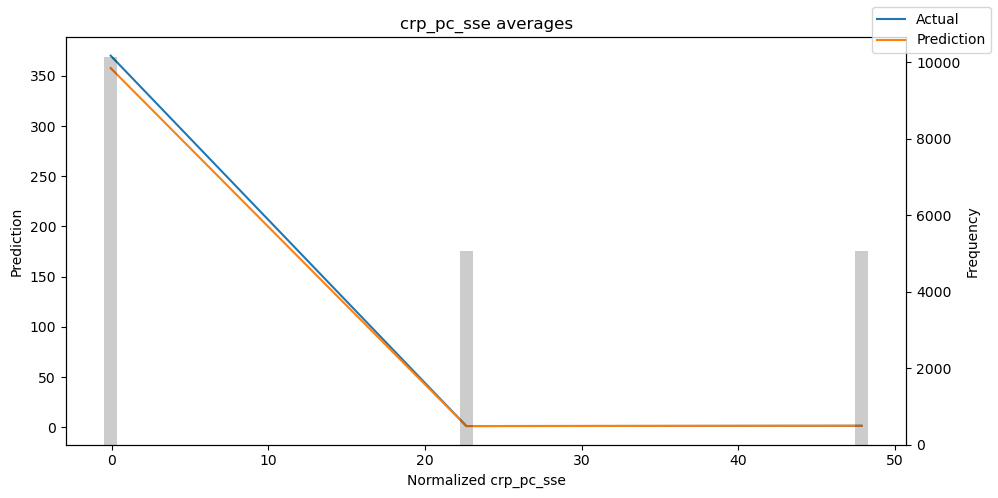

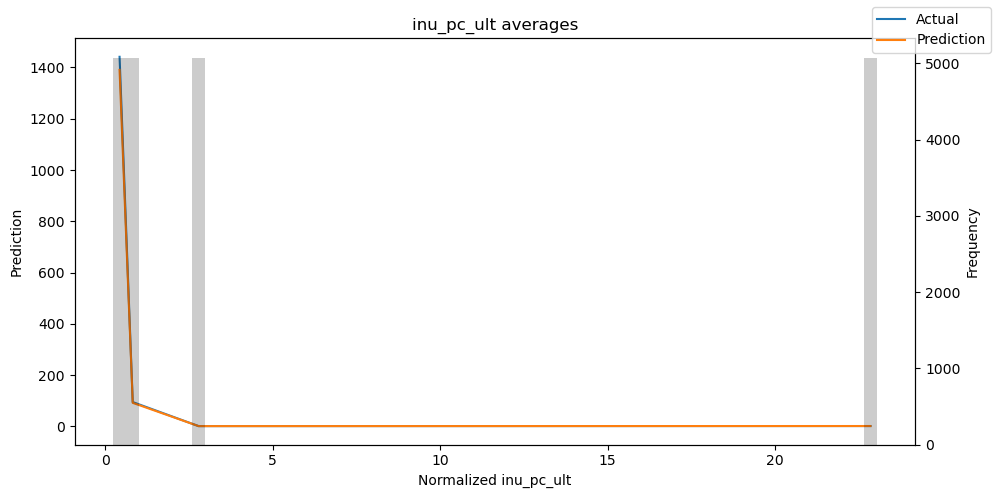

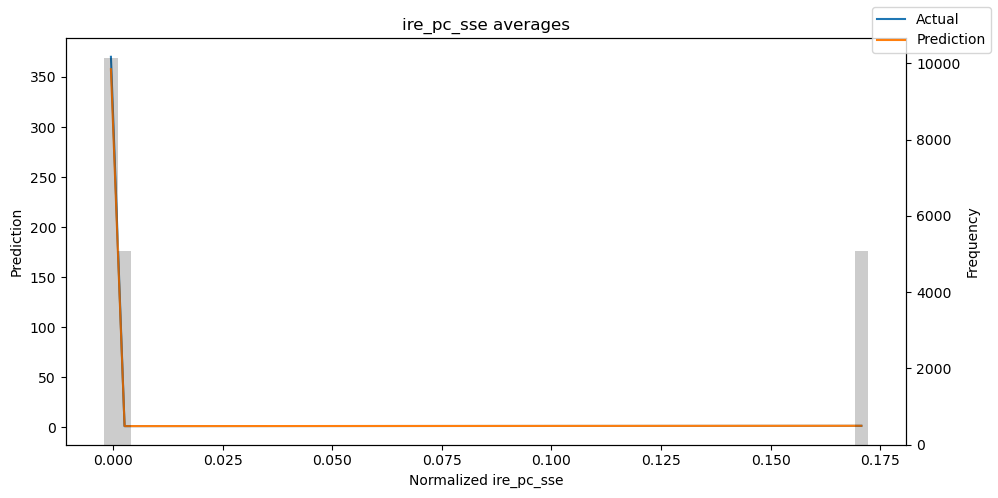

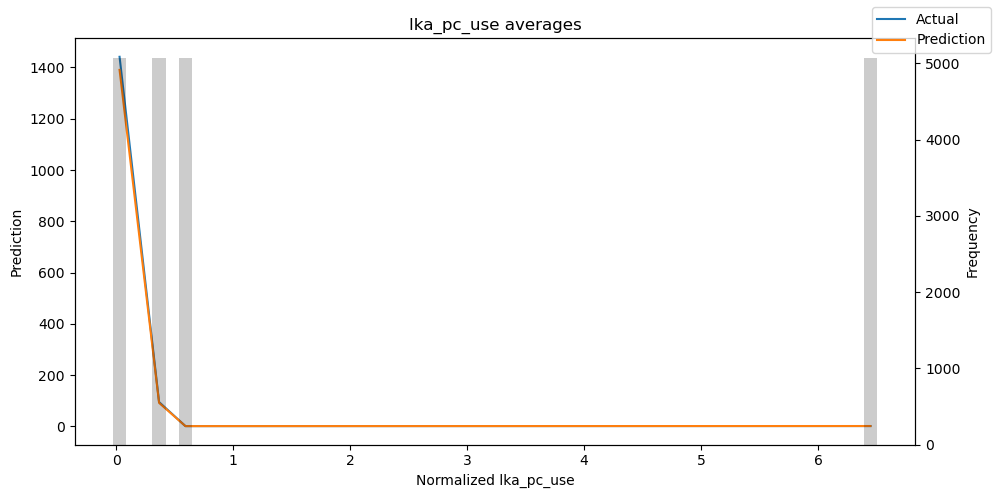

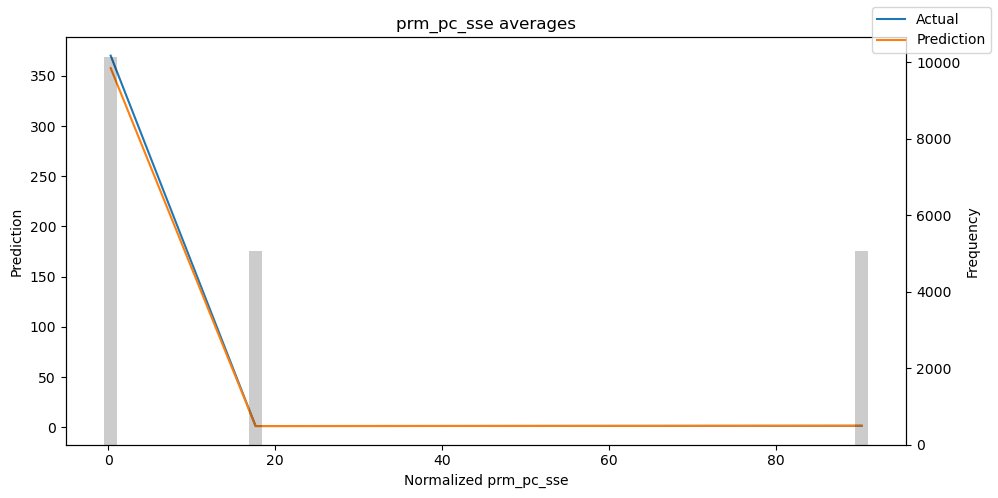

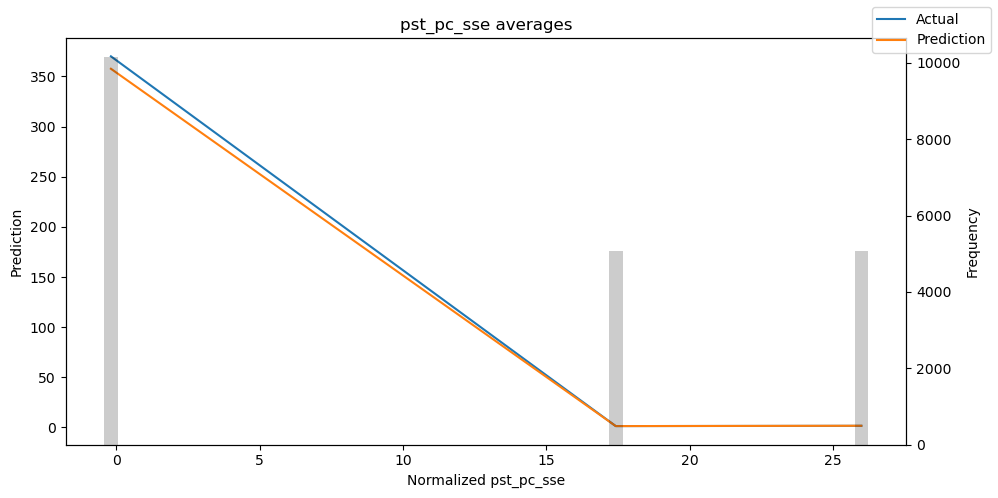

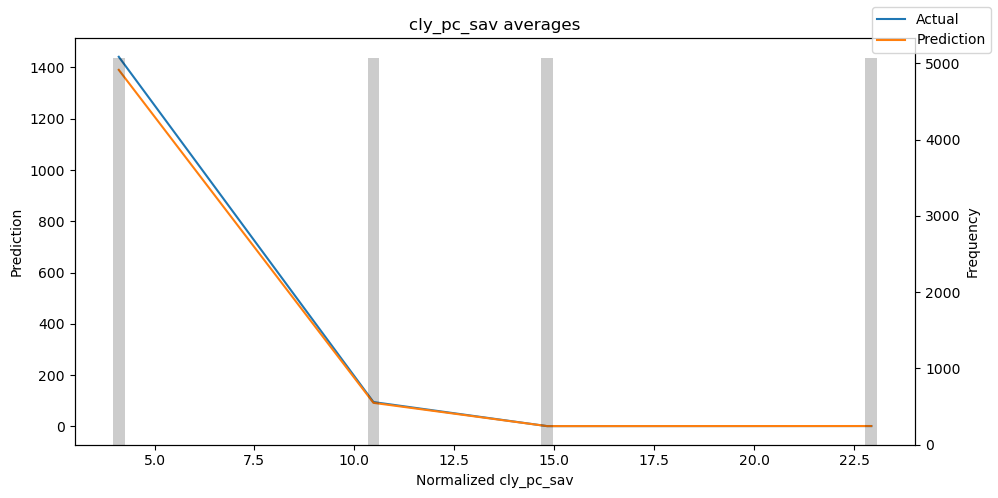

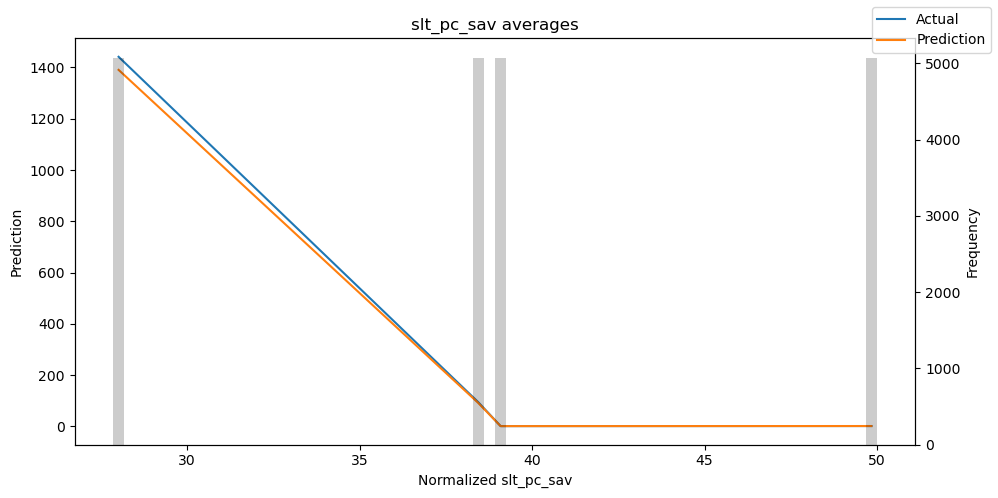

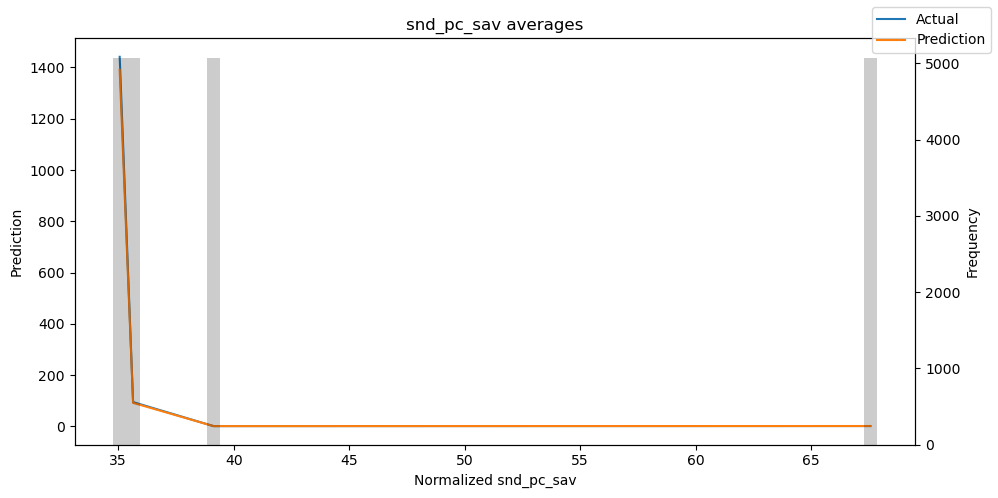

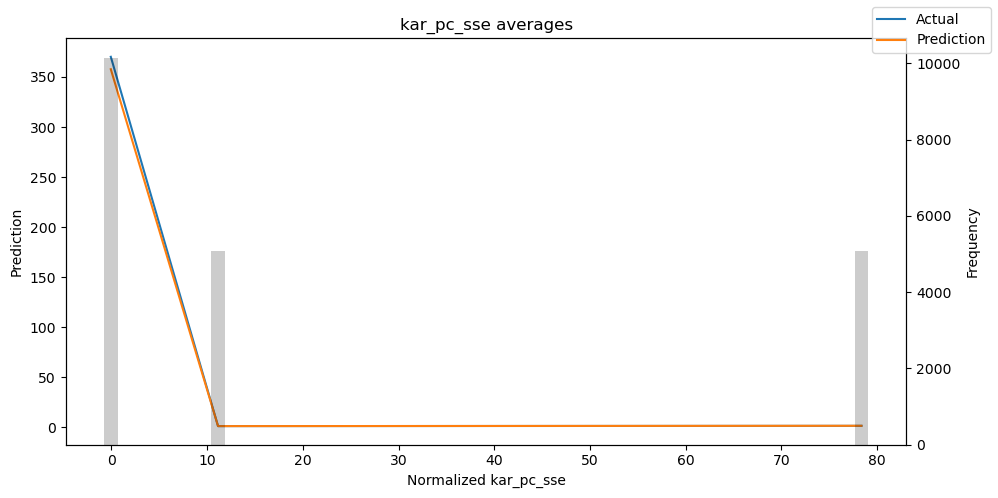

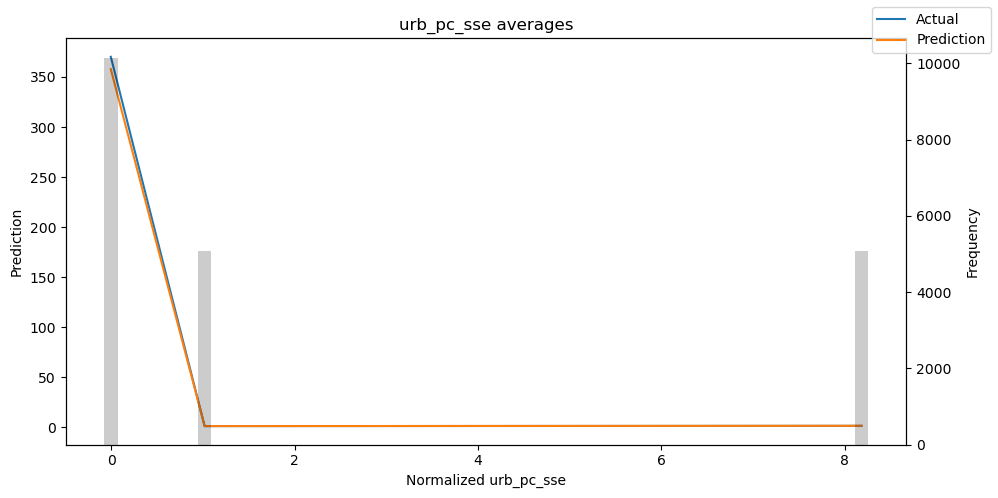

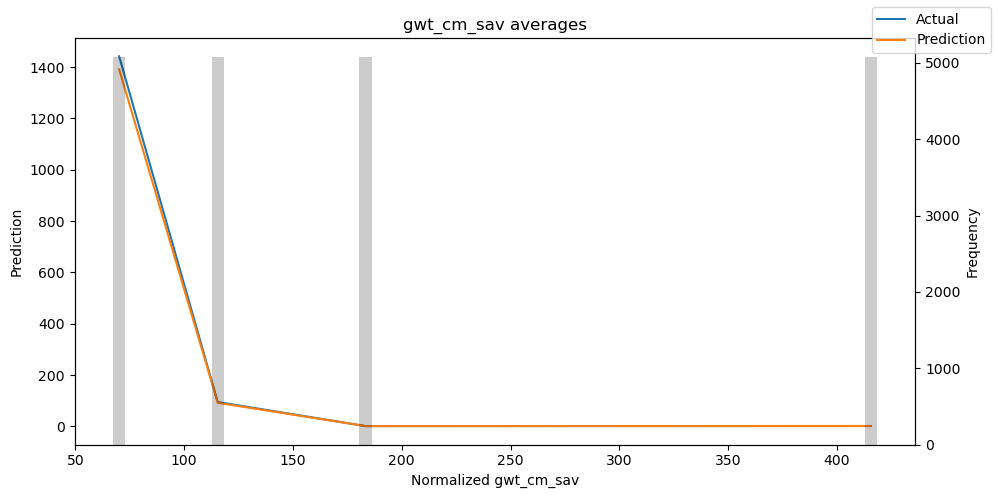

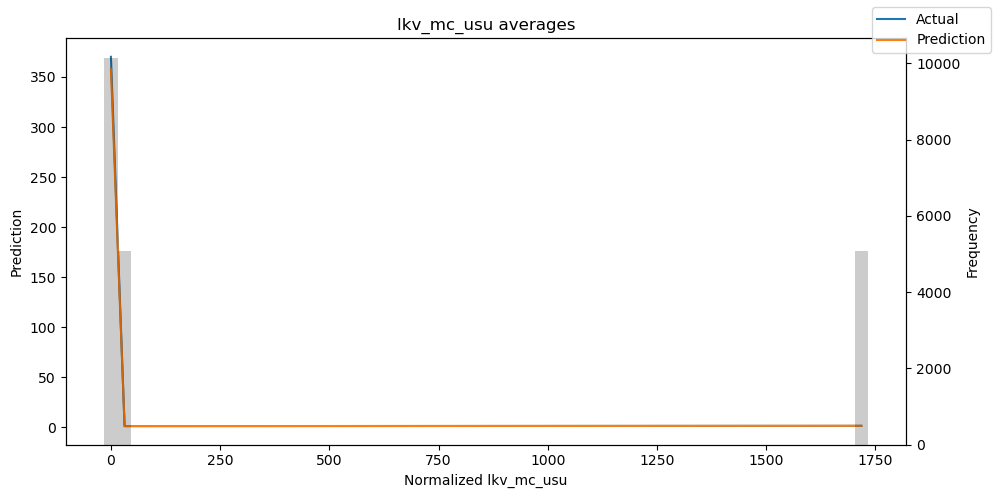

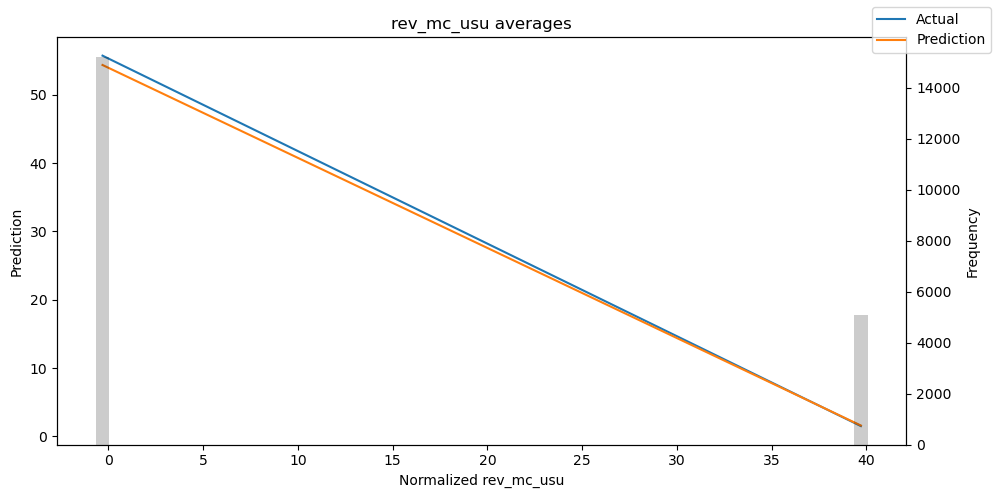

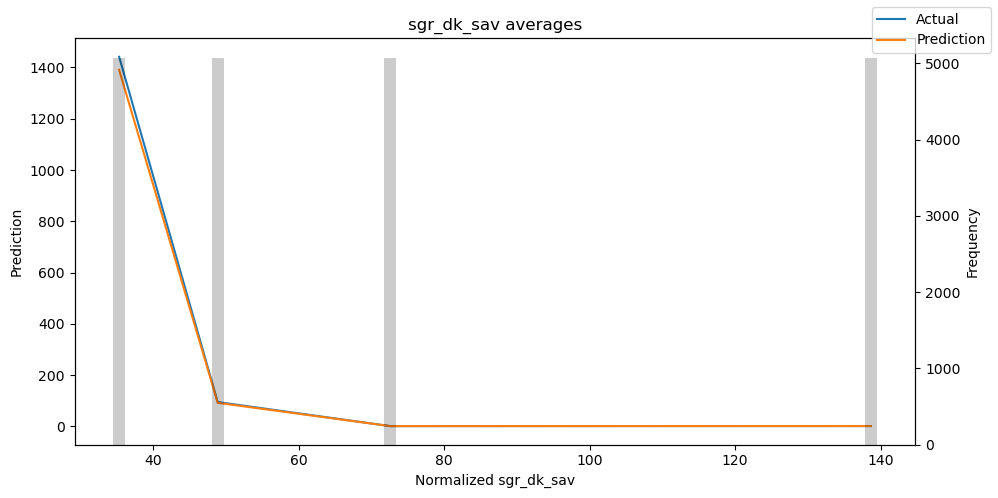

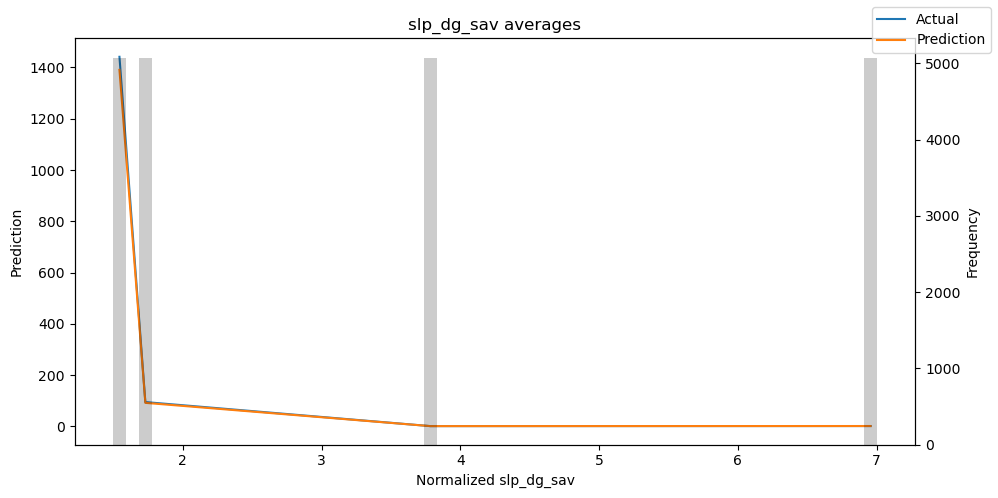

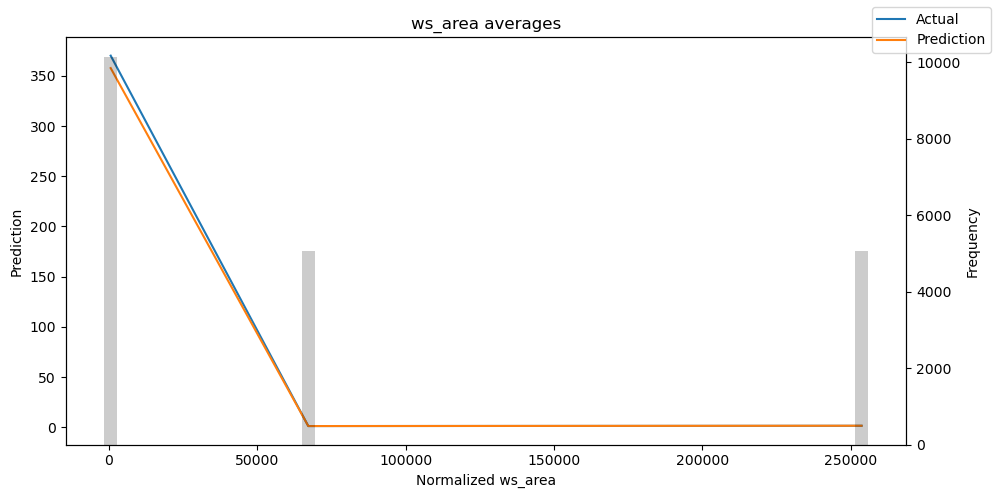

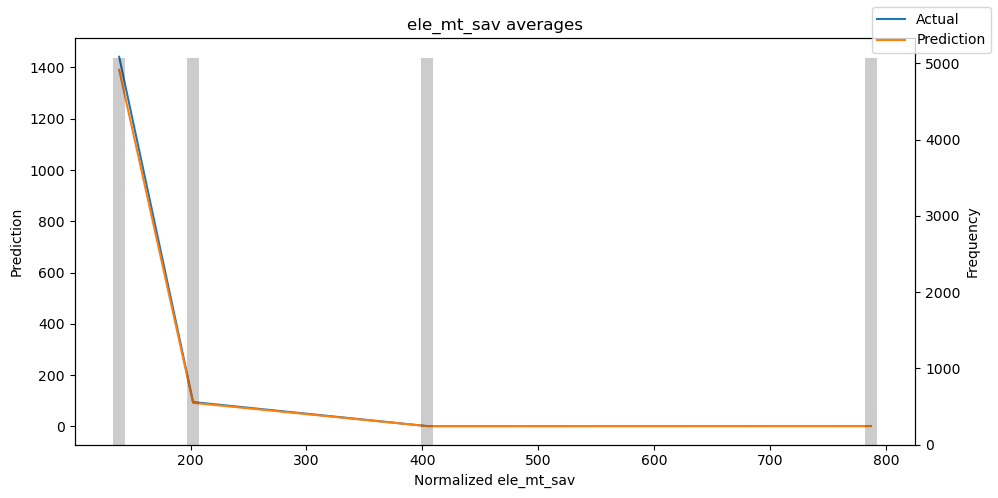

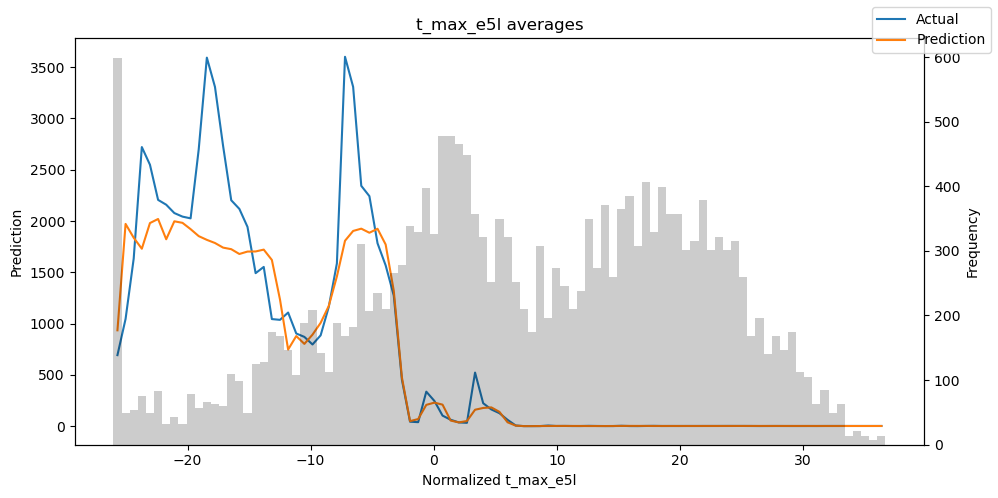

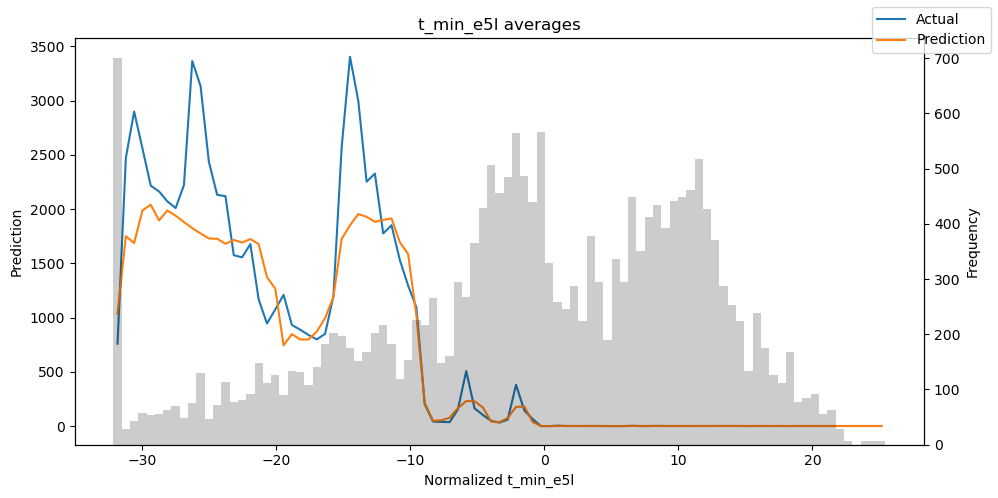

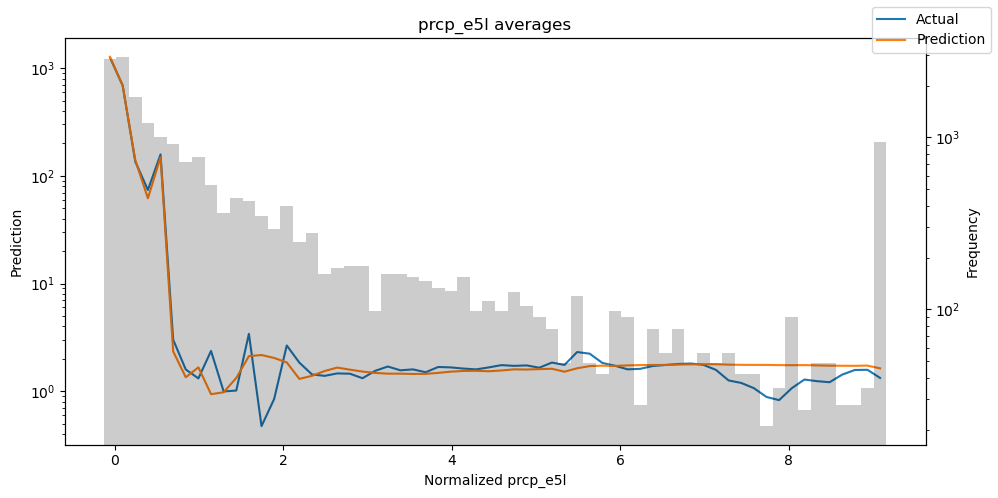

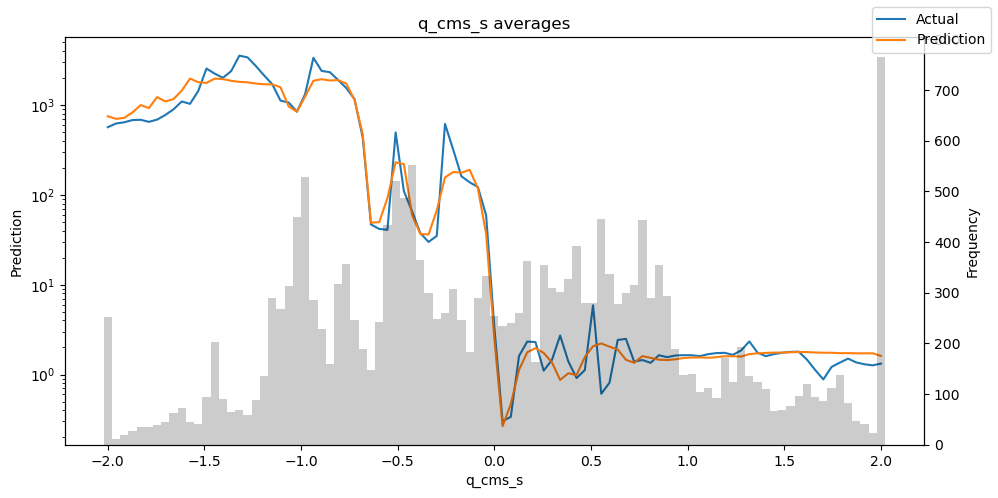

In [38]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

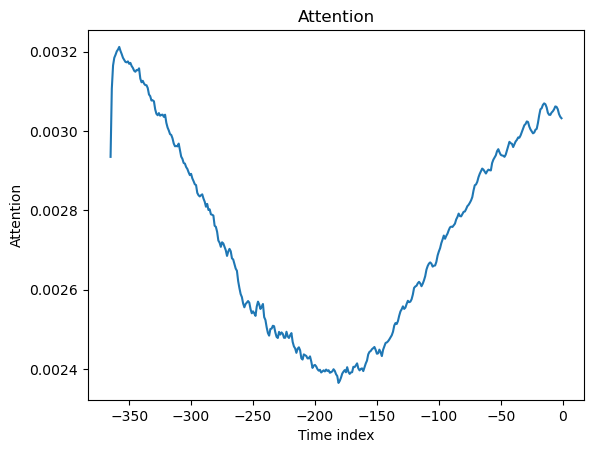

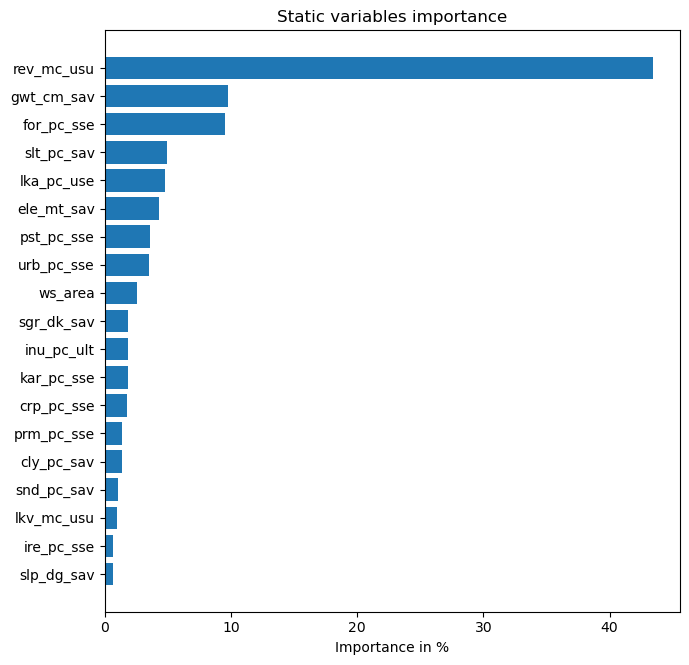

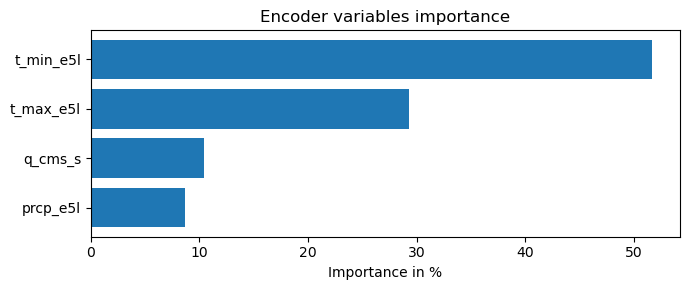

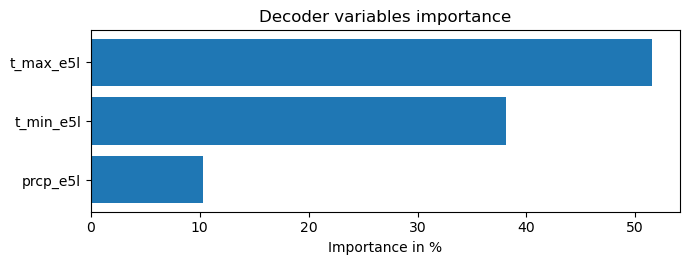

In [42]:
interpretation = best_tft.interpret_output(raw_prediction, reduction="sum")
best_tft.plot_interpretation(interpretation);

In [ ]:
geo_folder = '../geo_data/great_db'

forecast_data = HydroForecastData(
    nc_files=glob.glob(f'{geo_folder}/nc_concat/*.nc')[:5],
    gauges=['5746', '3159', '8376'],
    predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'],
    target=['lvl_sm'],
    hydroatlas_path='../geo_data/static_attributes/geo_vector.csv',
    hydroatlas=['for_pc_sse', 'crp_pc_sse', 'inu_pc_ult',
                'ire_pc_sse', 'lka_pc_use', 'prm_pc_sse',
                'pst_pc_sse', 'cly_pc_sav', 'slt_pc_sav',
                'snd_pc_sav', 'kar_pc_sse', 'urb_pc_sse',
                'gwt_cm_sav', 'lkv_mc_usu', 'rev_mc_usu',
                'sgr_dk_sav', 'slp_dg_sav', 'ws_area',
                'ele_mt_sav'],
    h_bs_file='../ais_parsers/data/height_gauge.csv',
    future_interval=7, past_interval=365,
    train_start='01/01/2008', train_end='12/31/2015',
    val_start='01/01/2016', val_end='12/31/2018',
    test_start='01/01/2019', test_end='12/31/2020')
# store static data for further concat in decoder
static_attributes = forecast_data.static_attributes
# Here we are defining properties for our model

# Training batch size
BATCH_SIZE = 128
# so called torch Datasets
train_ds, val_ds, test_ds = forecast_data.train_val_test()
# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True)

dataloaders = {x: dl for x, dl
               in zip(['train', 'val', 'test'],
                      [train_loader, val_loader, test_loader])}
datasizes = {x: len(dl) for x, dl in dataloaders.items()}
# Observe that all parameters are being optimized
# Device selection (CPU | GPU)
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
print(f"We'll utlize {device} in further calculations")

We'll utlize cpu in further calculations
